# IMAGINE tutorial 2 -- another example.

### (Using a different toy model for the field and its corresponding toy simulator.)

In Tutorial 1, we briefly reviewed the basic features in IMAGINE.

This tutorial will not teach you new features in IMAGINE, but does the same analysis on a different field model. This will give you an idea of how some fields are easier to determine than others using these methods. 

The field in this tutorial is designed to mimick emission intensities which is roughly proportional to (Galactic) magnetic field energy density, e.g. field  strength squared.

$ signal(x) = [sin(x) * \mathcal{G}(mean=a0,std=b0;seed=s)]^2 $, $x \in (0,2\pi)$

You will see that the influence of having variance-like fluctuations in the observable differs dramatically from what we have seen in tutorial 1.

This tutorial has a threshold in data size, i.e. taking $ size<5 $ in this tutorial will fail.

sampling efficiency is highly suppressed

<span style="color:red">**the following Bayesian sampling processes can be quite expensive**</span>

In [1]:
import numpy as np
import logging as log

from imagine import Simulations, Measurements, Covariances
from imagine import EnsembleLikelihood
from imagine import FlatPrior
from imagine import MultinestPipeline
from imagine.simulators.test.bi_simulator import BiSimulator
from imagine.fields.test_field.test_field_factory import TestFieldFactory
from imagine.tools.covariance_estimator import oas_cov

# visualize posterior
import corner
import matplotlib
from imagine.tools.carrier_mapper import unity_mapper
matplotlib.use('Agg')

%matplotlib inline

## step 1, prepare mock data

For explanation, see tutorial 1.

In [2]:
a0 = 6. # true value of a
b0 = 2. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 20
x = np.linspace(0,2.*np.pi,size)

np.random.seed(s)

signal = np.square (np.multiply (np.sin(x), np.random.normal(loc=a0,scale=b0,size=size)))

data = np.vstack([signal + np.random.normal(loc=0.,scale=e,size=size)])

cov = (e**2) * np.eye(size)

mock_data = Measurements()
mock_data.append(('test', 'nan', str(size), 'nan'), data, True)

mock_cov = Covariances() # create empty Covariance object
mock_cov.append(('test', 'nan', str(size), 'nan'), cov, True)

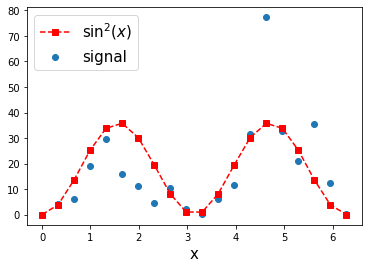

In [3]:
fig,ax = matplotlib.pyplot.subplots()
ax.scatter(x, mock_data[('test', 'nan', str(size), 'nan')].global_data[0], marker='o', label='signal')
ax.plot(x,(np.sin(x)*a0)**2,'r--',marker='s',label='$\sin^2(x)$')
ax.set_xlabel('x',fontsize=15); ax.legend(fontsize=15);

## step 2, prepare pipeline
The simulator used for this example is BiSimulator, consisting of the emissivity function defined above.

In [4]:
factory = TestFieldFactory(active_parameters=('a','b'))
factory.parameter_ranges = {'a':(0,10),'b':(0,10)}
factory_list = [factory]

simer = BiSimulator(mock_data) # now we use a different simulator

prior = FlatPrior()

likelihood = EnsembleLikelihood(mock_data, mock_cov)

ensemble_size = 100
pipe = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_type = 'controllable'
pipe.seed_tracer = 23
pipe.sampling_controllers = {'n_iter_before_update': 1,
                             'n_live_points': 400,
                             'verbose': True,
                             'resume': False}

## step 3, run pipeline

Or turn to the **example** directory and run the corresponding pipeline with MPI support.

In [5]:
results = pipe()

  analysing data from chains/imagine_.txt


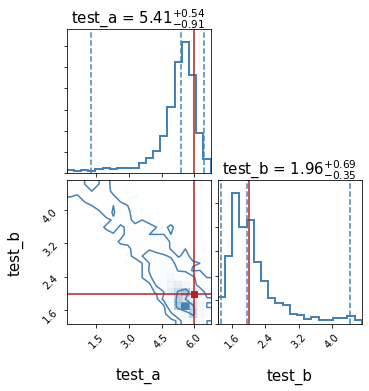

In [6]:
samples = results['samples']  # load sample points

## convert from pipeline-internal (0-1) values into physical parameters
for i in range(len(pipe.active_parameters)): 
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j,i] = unity_mapper(samples[j,i],low,high)

##  See https://corner.readthedocs.io/en/latest/pages/sigmas.html about contour levels.  
##  "Contours are shown at 0.5, 1, 1.5, and 2 sigma" by default
##  according to https://pypi.org/project/corner/1.0.1/, but I want 1, 2, and 3.
sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)

# Visualize with a corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                      range=[0.99]*len(pipe.active_parameters),
                      quantiles=[0.02, 0.5, 0.98],
                      labels=pipe.active_parameters,
                      show_titles=True,
                      title_kwargs={"fontsize": 15},
                      color='steelblue',
                      truths=[a0,b0],
                      truth_color='firebrick',
                      plot_contours=True,
                      hist_kwargs={'linewidth': 2},
                      label_kwargs={'fontsize': 15},
                      levels=levels)

## step 3a, run pipeline with Dynesty

iter: 3310 | +400 | bound: 118 | nc: 1 | ncall: 94440 | eff(%):  3.928 | loglstar:   -inf < -70.285 <    inf | logz: -77.755 +/-  0.183 | dlogz:  0.001 >  0.409                                      

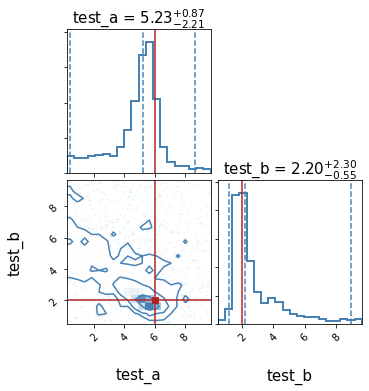

In [7]:
from imagine.pipelines.dynesty_pipeline import DynestyPipeline

pipe = DynestyPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_type = 'free'
pipe.sampling_controllers = {'nlive': 400} # mind the difference here

results = pipe()
samples = results['samples']
for i in range(len(pipe.active_parameters)):
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j, i] = unity_mapper(samples[j, i], low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## convergence check

iter: 3228 | +400 | bound: 104 | nc: 1 | ncall: 83068 | eff(%):  4.368 | loglstar:   -inf < -70.573 <    inf | logz: -77.816 +/-  0.181 | dlogz:  0.001 >  0.409                                      

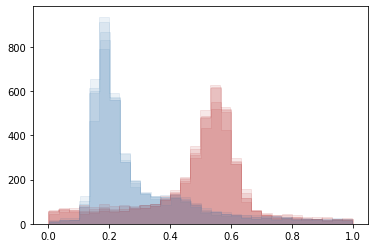

In [8]:
from scipy.stats import norm
repeat = 5

for i in range(repeat):
    tmp = pipe()
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    matplotlib.pyplot.hist(asamp,30,histtype='step',stacked=True,fill=True,color='firebrick',alpha=0.1)
    matplotlib.pyplot.hist(bsamp,30,histtype='step',stacked=True,fill=True,label='b',color='steelblue',alpha=0.1)

### This ends tutorial 2. Continue to tutorials 3-5:
The python script for tutorial 2 can be found in [bi_multinest](https://bitbucket.org/hammurabicode/imagine/src/master/examples/test_examples/bisimulator_multinest.py) and [bi_dynesty](https://bitbucket.org/hammurabicode/imagine/src/master/examples/test_examples/bisimulator_dynesty.py)

* [Tutorial 3](tutorial_three.ipynb):  On calling hammurabiX and/or setting it up for use in an IMAGINE pipeline
* [Tutorial 4](tutorial_four.ipynb):  Data masking
* [Tutorial 5](tutorial_five.ipynb):  An almost realistic pipeline run

Or see more examples in the *imagine/examples* directory